Hypothesis 3: Removing the Asian subgroup can improve the performance of the model to recognize the White since there will be no other light-skin subgroup in the training dataset. However, the most incorrect subgroup will be the Asian.  

In this experiment, I will first show dataframe and visualization of the original dataset which includes 23705 facial images of five races (White, Black, Asian, Indian and Other). Then, I will create a balanced dataset of all races, followed by training a model to show the correct/incorrect prediction. Finally I will create another balanced dataset without the Asian subpopulation.

My experiment shows that if we remove the Asian from the balanced training dataset, it is good at predicting the White subgroup while bad at recognizing the Asian. 

In [1]:
'''Run the comments below if you have not installed those libraries yet'''
#!{sys.executable} -m pip install tensorflow==2.4
#!{sys.executable} -m pip install plotly # Used to create charts in analysis section
#!{sys.executable} -m pip install scikit-learn


import sys
import os
import pandas as pd
import tensorflow as tf
import PIL # Python Image Library
from IPython.display import Image, display # To show images
import numpy as np
import glob
import plotly.express as px # For histograms
import plotly.graph_objects as go # For pie charts
from sklearn.metrics import precision_score, recall_score # For performance metrics

#from sklearn.utils import shuffle

__Define constants__

In this part, I added dataset_dict in order to use the parse_dataset function in the next cell. The rest is the same.

In [2]:
dataset_folder_name = 'UTKFace'

# Label locations in the filename
AGE_INDEX = 0
GENDER_INDEX = 1
RACE_INDEX = 2

# Class labels
GENDER_MALE = 0
GENDER_FEMALE = 1
RACE_WHITE = 0
RACE_BLACK = 1
RACE_ASIAN = 2
RACE_INDIAN = 3
RACE_OTHER = 4

# Text labels for gender and race classes
GENDER_LABELS = {
    0: "male",
    1: "female"
}

RACE_LABELS = {
    0: "white",
    1: "black",
    2: "asian",
    3: "indian",
    4: "other"
}

#This dictionary is used to extract the file path since I could not used the starter code. 
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())


This helper function is useful to extract data info on Window OS but it not neccessary on Mac iOS
source: https://github.com/rodrigobressan/keras-multi-output-model-utk-face

In [29]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to get the filenames.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    
    return df

In [30]:
#Create a dataframe but I only used the 'file' column of this dataframe to extract info of interest.
data_df = parse_dataset(dataset_folder_name)

display(data_df.head())

age  gender   race                                            file
0  100.0    male  white  UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1  100.0    male  white  UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2  100.0  female  white  UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3  100.0  female  white  UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4  100.0  female  white  UTKFace\100_1_0_20170112213303693.jpg.chip.jpg

In [31]:
#Create dataset set on tensorflow framework which is in order.
full_ds = tf.data.Dataset.list_files(data_df['file'],shuffle = False)

image_count = tf.data.experimental.cardinality(full_ds).numpy()

#Shuffle the dataset.
full_ds = full_ds.shuffle(image_count,seed = 32, reshuffle_each_iteration = False)    

In [32]:
#This step checks if the dataset has been shuffled. 
print("Dataset size:", tf.data.experimental.cardinality(full_ds).numpy())
for f in full_ds.take(5):
    print(f.numpy())

Dataset size: 23705
b'UTKFace\\26_1_3_20170119193111002.jpg.chip.jpg'
b'UTKFace\\28_1_1_20170113012805025.jpg.chip.jpg'
b'UTKFace\\16_1_0_20170109214621700.jpg.chip.jpg'
b'UTKFace\\70_1_1_20170119205140215.jpg.chip.jpg'
b'UTKFace\\21_0_0_20170116201127126.jpg.chip.jpg'


# These are the original functions in the start code.

In [33]:
### FUNCTIONS FIRST USED IN THIS SECTION ###

def get_label(file_path, attribute_to_classify):
    '''
        Takes the file path of a UTKFace image and an attribute (the integer index of the 
        attribute in the file path) and returns the image's label for that attribute.
    '''
    # Split the path into components using the current OS's file path separator
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    return int(labels[attribute_to_classify])


def convert_file_path_to_df_row_dictionary(file_path, columns):
    '''
        Takes the file path of a UTKFace image and converts it to a dictionary with the
        format "feature_name e.g. gender": label_value. This dictionary can be added to
        a Pandas dataframe
    '''
    row = {}
    # Split the path into components using the current OS's file path separator
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    
    for i, col_name in enumerate(columns):
        row[col_name] = int(labels[i])
    return row 


def create_dataframe_from_dataset(ds):
    '''
        Takes a dataset of UTKFace images (that have not yet been converted into image:label pairs)
        and returns a dataframe containing one row for each image and a column for each label.
        This function is SLOW.
    '''
    COLS=["age", "gender", "race"]
    df = pd.DataFrame(columns=COLS) # Creates an empty dataframe with column headings
    for image in ds:
        image_path = str(image.numpy().decode("utf8"))
        row = convert_file_path_to_df_row_dictionary(image_path, COLS[0:3])
        df = df.append(row, ignore_index=True)
    return df


### VISUALIZATION FUNCTIONS ###
def draw_hist(df, col, nbins, title="Distribution"):
    '''
        Draws a Plotly histogram from the given data.
    '''
    fig = px.histogram(df, x=col, nbins=nbins)
    fig.update_layout(title_text=title)
    fig.show()
    

def draw_pie(df, col, title="Distribution", text_labels=None):
    '''
        Draws a Plotly pie chart from the given data.
    '''
    labels = df[col].value_counts().index.tolist()
    if text_labels != None:
        labels = [text_labels[val] for val in labels]
    counts = df[col].value_counts().values.tolist()

    plot = go.Pie(labels=labels, values=counts)
    fig = go.Figure(data=[plot])
    fig.update_layout(title_text=title)
    fig.show()
    
### FUNCTIONS FIRST USED IN THIS SECTION ###


def process_path(file_path, attribute_to_classify):
    '''
        Takes the file path of an image and the index of an attribute in the filename
        and returns the image data and the attribute label
    '''
    label = get_label(file_path, attribute_to_classify)
    # load the image from the file
    img_string = tf.io.read_file(file_path)
    # Get the raw data from the image
    img_data = tf.image.decode_jpeg(img_string, channels=3)
    return img_data, label

def process_path_age(file_path):
    '''
        Convenience function to get the age label from an image file path.
    '''
    return process_path(file_path, AGE_INDEX)


def process_path_gender(file_path):
    '''
        Convenience function to get the gender label from an image file path.
    '''
    return process_path(file_path, GENDER_INDEX)


def process_path_race(file_path):
    '''
        Convenience function to get the race label from an image file path.
    '''
    return process_path(file_path, RACE_INDEX)

def configure_for_performance(ds):
    BATCH_SIZE = 32
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def prepare_model(predicted_attribute):
    num_classes = 5 if predicted_attribute == RACE_INDEX else 1
    last_layer_activation = "linear" if predicted_attribute == AGE_INDEX \
                                     else "sigmoid" if predicted_attribute == GENDER_INDEX \
                                     else "softmax"
    
    layers = tf.keras.layers # A shorthand for creating the layers with fewer .
    
    return tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation=last_layer_activation)
    ])


def compile_model(model, predicted_attribute):
    loss_func=tf.losses.BinaryCrossentropy() if predicted_attribute == GENDER_INDEX \
              else tf.losses.SparseCategoricalCrossentropy() if predicted_attribute == RACE_INDEX \
              else tf.losses.MSE
    metric="mae" if predicted_attribute == AGE_INDEX else "accuracy"
    
    model.compile(
        optimizer="adam",
        loss=loss_func,
        metrics=metric
    )
    
def get_prediction_binary(newModel,input_example):
    '''
        Converts the probability returned by the binary classifier to a class label
    '''
    predictions = (newModel.predict(input_example) > 0.5).astype("int32")
    return predictions[0][0]


def get_prediction_multiclass(newModel,input_example):
    '''
        Returns the predicted class (multi-class classification)
    '''
    prediction = np.argmax(newModel.predict(input_example), axis=-1)
    return prediction[0]


def get_prediction_linear(newModel,input_example):
    '''
        Returns the predicted value (linear regression)
    '''
    prediction = newModel.predict(input_example)
    return prediction[0][0]


def is_correct_categorical(predicted, actual):
    '''
        Checks if the predicted label matches the actual label (for categorical classification, either
        binary or multi-class)
    '''
    return predicted == actual


def is_correct_linear(predicted, actual, tolerance=0.5):
    '''
        Checks if the predicted value is within the actual value plus or minus the
        given tolerance. Default tolerance is 0.5.
    '''
    return predicted >= actual - tolerance and predicted <= actual + tolerance


def get_detailed_results(ds,newModel, predicted_attribute, tolerance=0.5):
    '''
        Gets predictions for each image in a dataset of file paths. predicted_attribute
        is a string describing the class the model is predicting e.g. gender. Returns a dataframe 
        containing all class labels and the outcome of the prediction (correct or not).
    '''
    COLS = ["age", "gender", "race", "image_path", "is_correct"]
    df = pd.DataFrame(columns=COLS)
    for image in ds:
        img_string = tf.io.read_file(image)
        img_data = tf.image.decode_jpeg(img_string, channels=3)
        img_expanded = np.expand_dims(img_data, axis=0)
        prediction = get_prediction_binary(newModel, img_expanded) if predicted_attribute == "gender" \
                     else get_prediction_multiclass(newModel, img_expanded) if predicted_attribute == "race" \
                     else get_prediction_linear(newModel, img_expanded)
        row = convert_file_path_to_df_row_dictionary(image.numpy(), COLS[0:3])
        row["image_path"] = image.numpy().decode("utf8")
        row["is_correct"] = is_correct_linear(prediction, row[predicted_attribute], tolerance) if predicted_attribute == "age" \
                            else is_correct_categorical(prediction, row[predicted_attribute])
        df = df.append(row, ignore_index=True)
    return df

In [34]:
#This cell is to test if the parse_dataset function could actually work with the starter code
full_df = create_dataframe_from_dataset(full_ds)

print("Created dataframe with", full_df.shape[0], "rows") 
full_df.head() 

Created dataframe with 23705 rows


age gender race
0  26      1    3
1  28      1    1
2  16      1    0
3  70      1    1
4  21      0    0

# Explore the composition of the original dataset.

In [35]:
draw_hist(full_df, "age", 100, "Age distribution - full dataset")
draw_pie(full_df, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(full_df, "race", "Race distribution - full dataset",RACE_LABELS)

# Spliting Training and Testing dataset

Since this training dataset is not used to fit the model, i will not split it to training and validation dataset. Training and testing proportion is 80 and 20 respectively.  

In [36]:
image_count = tf.data.experimental.cardinality(full_ds).numpy()

# Calculate the number of examples that should be in the test set (20% of the full dataset)
test_size = int(image_count * 0.2)

# Create a temporary dataset of everything EXCEPT the first 20%
train_ds = full_ds.skip(test_size)

# Create the test set by taking the first 20% of the full dataset
test_ds = full_ds.take(test_size)

# Create a balanced dataset

In [37]:
# Create separate datasets for each label you want to set the representation of. E.g. equal balance of race and gender
# Start from the orginal datasets that contain the image file paths
def is_gender_and_race(file_path, gender_label, race_label):
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    return int(labels[GENDER_INDEX]) == gender_label and int(labels[RACE_INDEX]) == race_label

#extract the dataset according to the race and the gender of interest. 
black_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_BLACK))
black_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_BLACK))
white_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_WHITE))
white_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_WHITE))
asian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_ASIAN))
asian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_ASIAN))
indian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_INDIAN))
indian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_INDIAN))
other_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_OTHER))
other_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_OTHER))


len_bf = len(list(black_f_ds.as_numpy_iterator()))
len_bm = len(list(black_m_ds.as_numpy_iterator()))
len_wf = len(list(white_f_ds.as_numpy_iterator()))
len_wm = len(list(white_m_ds.as_numpy_iterator()))
len_af = len(list(asian_f_ds.as_numpy_iterator()))
len_am = len(list(asian_m_ds.as_numpy_iterator()))
len_if = len(list(indian_f_ds.as_numpy_iterator()))
len_im = len(list(indian_m_ds.as_numpy_iterator()))
len_of = len(list(other_f_ds.as_numpy_iterator()))
len_om = len(list(other_m_ds.as_numpy_iterator()))


#find the minimum element in each subgroup 
n = min(len_bf, len_bm, len_wf, len_wm,len_af, len_am, len_if,len_im,len_of,len_om)

#merge all the dataset and create a balanced one and shuffle.
train_ds_balanced = black_f_ds.take(n) \
                    .concatenate(black_m_ds.take(n)) \
                    .concatenate(white_f_ds.take(n)) \
                    .concatenate(white_m_ds.take(n)) \
                    .concatenate(asian_f_ds.take(n)) \
                    .concatenate(asian_m_ds.take(n)) \
                    .concatenate(indian_f_ds.take(n)) \
                    .concatenate(indian_m_ds.take(n)) \
                    .concatenate(other_f_ds.take(n)) \
                    .concatenate(other_m_ds.take(n)) \
                    .shuffle(n * 10, reshuffle_each_iteration = False)

# New training set length - For some unknown reason, Tensorflow can't find the cardinality of the filtered dataset so...
new_train_size = len(list(train_ds_balanced.as_numpy_iterator()))
print("Balanced training set length:", new_train_size) # Quite a bit smaller!

Balanced training set length: 6060


In [38]:
# Split the train_val dataset into train (80% of the images) and validation (20%)
val_size_balanced = int(tf.data.experimental.cardinality(train_ds_balanced).numpy() * 0.2)
train_ds_balanced = train_ds_balanced.skip(val_size_balanced)
val_ds_balanced = train_ds_balanced.take(val_size_balanced)

In [39]:
# Create the image:label datasets for the train, validation, and test sets
train_ds_race = train_ds_balanced.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_race = val_ds_balanced.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_race = test_ds.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)


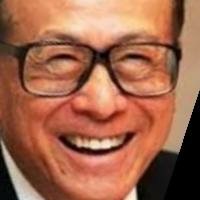

Gender asian 



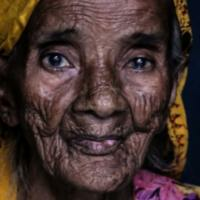

Gender indian 



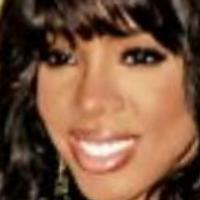

Gender black 



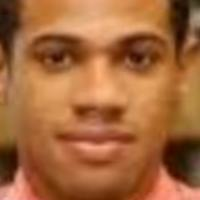

Gender black 



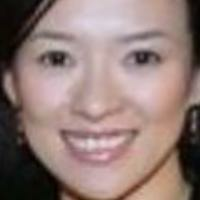

Gender asian 



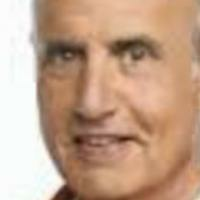

Gender indian 



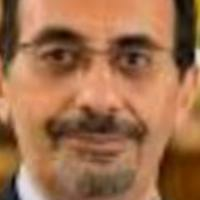

Gender indian 



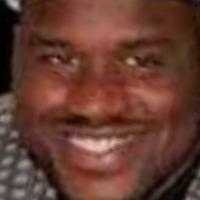

Gender black 



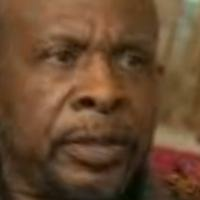

Gender black 



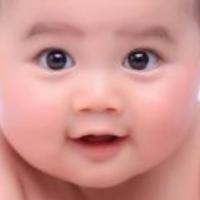

Gender asian 



In [40]:
# Check a subset of images by displaying them along with their labels
for image, label in train_ds_race.take(10):
    # Displays an image from its raw data.
    display(PIL.Image.fromarray(image.numpy()))
    print("Gender", RACE_LABELS[label.numpy()], "\n")


In [41]:
#Create dataframe for the balanced train dataset.
balanced_df = create_dataframe_from_dataset(train_ds_balanced)

In [42]:
#Create Visualization for gender distribution and racial distribution of the balanced training dataset.
draw_pie(balanced_df, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(balanced_df, "race", "Race distribution - full dataset",RACE_LABELS)

In [43]:
#Configure the training, testing and validation dataset to fit the model.
train_ds_race = configure_for_performance(train_ds_race)
val_ds_race = configure_for_performance(val_ds_race)
test_ds_race = configure_for_performance(test_ds_race)

In [44]:
#Train the model and validate its performance
model = prepare_model(RACE_INDEX)
compile_model(model, RACE_INDEX)

model.fit(
    train_ds_race,
    validation_data=val_ds_race,
    epochs=3
)

Epoch 1/3
190/190 [==============================] - 111s 525ms/step - loss: 1.5240 - accuracy: 0.3172
Epoch 2/3
190/190 [==============================] - 106s 559ms/step - loss: 1.0070 - accuracy: 0.6106
Epoch 3/3
190/190 [==============================] - 103s 543ms/step - loss: 0.8550 - accuracy: 0.6750


In [45]:
#Evaluating the performance of the model.
test_results = model.evaluate(test_ds_race)
print(test_results)

149/149 [==============================] - 17s 111ms/step - loss: 0.9299 - accuracy: 0.6602
[0.9299106597900391, 0.6601982712745667]


In [46]:
race_results = get_detailed_results(test_ds, model, "race")
display(race_results.head())

# Create a dataframe containing only the rows where the condition is met--the classifier predicted correctly
correct = race_results[race_results["is_correct"] == True] 
incorrect = race_results[race_results["is_correct"] == False]

num_correct = float(correct.shape[0])
total = float(race_results.shape[0])
print("Overall accuracy", num_correct / total)

age gender race                                     image_path is_correct
0  26      1    3  UTKFace\26_1_3_20170119193111002.jpg.chip.jpg       True
1  28      1    1  UTKFace\28_1_1_20170113012805025.jpg.chip.jpg       True
2  16      1    0  UTKFace\16_1_0_20170109214621700.jpg.chip.jpg       True
3  70      1    1  UTKFace\70_1_1_20170119205140215.jpg.chip.jpg      False
4  21      0    0  UTKFace\21_0_0_20170116201127126.jpg.chip.jpg      False

Overall accuracy 0.6601982704070871


__Visualize performance__

Now we're going to use the charting functions from earlier to compare the distributions of each attribute in the correct predictions to those in the incorrect predictions.

In [47]:
draw_pie(correct, "race", "Race - correct predictions", RACE_LABELS)
draw_pie(incorrect, "race", "Race - incorrect predictions", RACE_LABELS)

Even though the White subpopulation is the most correct group, it is also the most incorrect one. From my prediction, this is due to light skin-tone of Asian which is incorrectly recognize as the White and reversely. Thus, the next step to test my hypothesis is to remove the Asian group to see if the performance of the model is better to recognize the White.

In [48]:
x = min(len_bf, len_bm, len_wf, len_wm, len_if,len_im,len_of,len_om)

train_ds_no_asian = black_f_ds.take(x) \
                    .concatenate(black_m_ds.take(x)) \
                    .concatenate(white_f_ds.take(x)) \
                    .concatenate(white_m_ds.take(x)) \
                    .concatenate(indian_f_ds.take(x)) \
                    .concatenate(indian_m_ds.take(x)) \
                    .concatenate(other_f_ds.take(x)) \
                    .concatenate(other_m_ds.take(x)) \
                    .shuffle(x * 8)

# New training set length - For some unknown reason, Tensorflow can't find the cardinality of the filtered dataset so...
new_train_size = len(list(train_ds_no_asian.as_numpy_iterator()))
print("Balanced training set length:", new_train_size) # Quite a bit smaller!

Balanced training set length: 4848


In [49]:
#Create dataframe for the unbalanced train dataset.
unbalanced_df = create_dataframe_from_dataset(train_ds_no_asian)

In [50]:
#Create Visualization for gender distribution and racial distribution of the unbalanced training dataset.
draw_pie(unbalanced_df, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(unbalanced_df, "race", "Race distribution - full dataset",RACE_LABELS)

In [51]:
# Split the train_val dataset into train (80% of the images) and validation (20%)
val_size_balanced = int(tf.data.experimental.cardinality(train_ds_no_asian).numpy() * 0.2)
train_ds_no_asian = train_ds_no_asian.skip(val_size_balanced)
val_ds_no_asian = train_ds_no_asian.take(val_size_balanced)

In [52]:
# Create the image:label datasets for the train, validation, and test sets
train_ds_no_asian = train_ds_no_asian.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_no_asian = val_ds_no_asian.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_race = test_ds.map(process_path_race, num_parallel_calls=tf.data.AUTOTUNE)

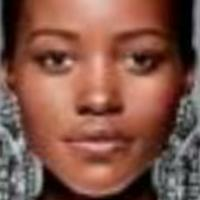

Gender black 



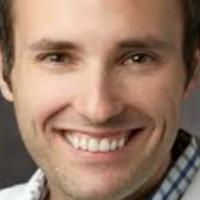

Gender other 



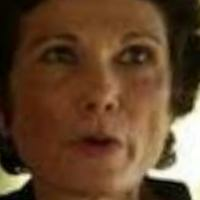

Gender white 



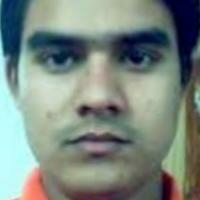

Gender indian 



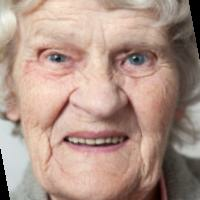

Gender white 



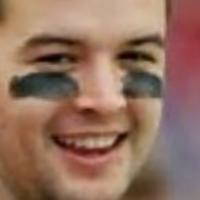

Gender white 



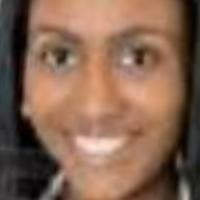

Gender indian 



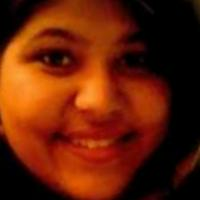

Gender indian 



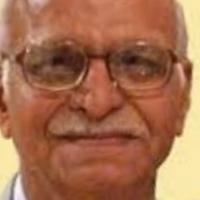

Gender indian 



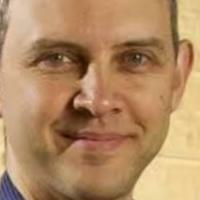

Gender other 



In [53]:
# Check a subset of images by displaying them along with their labels
for image, label in train_ds_no_asian.take(10):
    # Displays an image from its raw data.
    display(PIL.Image.fromarray(image.numpy()))
    print("Gender", RACE_LABELS[label.numpy()], "\n")


In [54]:
#Preparing the training, testing and validating datasets. 
train_ds_no_asian=configure_for_performance(train_ds_no_asian)
val_ds_no_asian = configure_for_performance(val_ds_no_asian)
test_ds_race = configure_for_performance(test_ds_race)

In [55]:
#Train the model and validate its performance

model2 = prepare_model(RACE_INDEX)
compile_model(model2, RACE_INDEX)

model2.fit(
    train_ds_no_asian,
    validation_data=val_ds_no_asian,
    epochs=3
)

Epoch 1/3
152/152 [==============================] - 92s 544ms/step - loss: 1.4239 - accuracy: 0.3307
Epoch 2/3
152/152 [==============================] - 83s 546ms/step - loss: 0.9408 - accuracy: 0.6017
Epoch 3/3
152/152 [==============================] - 83s 549ms/step - loss: 0.8122 - accuracy: 0.6753


In [ ]:
#Evaluating the performance of the model.

test_results_no_asian = model2.evaluate(test_ds_race)
print(test_results_no_asian)

107/149 [====================>.........] - ETA: 4s - loss: 2.7219 - accuracy: 0.5596

# Evaluating the accuracy of the model
The following functions are slightly modified their name of the model2 and each name of the helper functions

In [ ]:
no_asian_results = get_detailed_results(test_ds, model2 "race")
display(no_asian_results.head())

# Create a dataframe containing only the rows where the condition is met--the classifier predicted correctly
new_correct = no_asian_results[no_asian_results["is_correct"] == True] 
new_incorrect = no_asian_results[no_asian_results["is_correct"] == False]

new_num_correct = float(new_correct.shape[0])
new_total = float(no_asian_results.shape[0])
print("Overall accuracy", new_num_correct / new_total)

In [ ]:
draw_pie(new_correct, "race", "Race - correct predictions", RACE_LABELS)
draw_pie(new_incorrect, "race", "Race - incorrect predictions", RACE_LABELS)

# Conclusion
According to the above result, my Hypothese is correct  the performance of the model, which has been trained without 
the Asian subgroup, indicates that the model indeed classifies the White subgroup more correctly and unsurprisingly, 
the Asian one will be the most misclassified. Thus, this experiment implies that any unbalanced dataset could lead 
to many possible errors in the classfication model and the vulnerable subgroup is the one who were left out of the 
training dataset. 
